VAE model for EEG Data Augmentation

link: https://github.com/arkanivasarkar/EEG-Data-Augmentation-using-Variational-Autoencoder

Paper: https://arxiv.org/pdf/1611.08024.pdf


Referências:

https://www.tensorflow.org/tutorials/keras/save_and_load?hl=pt-br

##Loading libraries

In [39]:
pip install np_utils

ERROR: Operation cancelled by user


In [40]:
!pip install braindecode==0.7
!pip install moabb

In [41]:
!pip install umap-learn
import umap

In [42]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

torch.manual_seed(0) # Set for our testing purposes, please do not change!

from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows
from sklearn.preprocessing import scale as standard_scale

In [43]:
#bibliotecas para carregar o dataset e para arquitetura da rede
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K

In [44]:
#bibliotecas para visualização do espaço latente
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


## Reading the data

In [45]:
def preprocessor(
    dataset,
    low_cut_hz = 4.,   # low cut frequency for filtering
    high_cut_hz = 38., # high cut frequency for filtering
    newfreq = 100, # Paramater for resampling
    factor = 1e6, # Parameter for scaling
    ):

    preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
#         Preprocessor(lambda data: np.multiply(data, factor)),  # Convert from V to uV
        Preprocessor("resample", sfreq=newfreq), # Resampling
        Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
        Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg"), # Common Average Reference
        Preprocessor(standard_scale, channel_wise=True) ## Standard Scale window
    ]

    # Transform the data
    # return preprocess(dataset, preprocessors, n_jobs = -1)
    return preprocess(dataset, preprocessors)


In [13]:
def get_windows(
        dataset,
        trial_start_offset_samples=0,
        trial_stop_offset_samples=100,
        window_size_samples=400,
        window_stride_samples=100,
        preload=True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        picks = ['C3', 'Cz', 'C4']
        ):

    windows_dataset = create_windows_from_events(
        dataset,
        trial_start_offset_samples = trial_start_offset_samples,
        trial_stop_offset_samples  = trial_stop_offset_samples,
        window_size_samples        = window_size_samples,
        window_stride_samples      = window_stride_samples,
        preload                    = True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        #picks                      = picks
        )

    # preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)]) ## Standard Scale window

    return windows_dataset


def get_tensors_from_windows(windows_dataset):
    windows_list = []
    labels_list = []
    n_runs = len(windows_dataset.datasets)
    for i in range(n_runs):
        windows_list.append(windows_dataset.datasets[i].windows.get_data())
        labels_list.append(windows_dataset.datasets[i].y)

    stacked_tensor = np.concatenate(windows_list, axis=0)
    stacked_labels = np.concatenate(labels_list, axis=0)

    del windows_list,labels_list

    return stacked_tensor, stacked_labels

In [14]:
class EEG(Dataset):

    def __init__(self, subject_id = 3, dataset_name="BNCI2014_001", transform = None):

        self.raw_dataset     = MOABBDataset(dataset_name = dataset_name, subject_ids=subject_id)
        self.prepro_dataset  = preprocessor(self.raw_dataset)
        self.windows_dataset = get_windows(self.prepro_dataset)
        self.data            = get_tensors_from_windows(self.windows_dataset)
        self.transform       = transform
        self.classes         = self.windows_dataset.datasets[0].windows.event_id

    def __len__(self):
        return self.data[0].shape[0]


    def __getitem__(self,idx):

        # sample = {'signal': torch.from_numpy(self.data[0])[idx], 'label': torch.from_numpy(self.data[1])[idx]}

        sample = (torch.from_numpy(np.expand_dims(self.data[0], axis = 1))[idx], torch.from_numpy(self.data[1])[idx])

        if self.transform:
            sample = self.transform(sample)

        return sample

In [15]:
my_eeg_data = EEG(subject_id=3)

/usr/local/lib/python3.10/dist-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 27.2GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 42.3M/42.3M [00:00<00:00, 15.5GB/s]
SHA256 hash of downloaded file: d4229267ec7624fa8bd3af5cbebac17f415f7c722de6cb676748f8cb3b717d97
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [16]:
x = my_eeg_data[:][0].detach().numpy()
eletrodos = x.shape[2]
amostras  = x.shape[3]
y = my_eeg_data[:][1].detach().numpy()

In [50]:
# Carregar os dados do arquivo
x_gen = torch.load('/content/drive/MyDrive/Unicamp/23.2/DL para sintese de sinais/Projetos computacionais/A1 - Projeto Final/Códigos/dados_gerados_todas_labels.pt')
x_gen = x_gen.detach().numpy()

# Criar os rótulos
y_gen = np.concatenate((np.zeros((288,1)),np.ones((288,1)),2*np.ones((288,1)),3*np.ones((288,1))))

In [51]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
X_train, X_test, y_train, y_test  = train_test_split(x_gen,y_gen,test_size=0.2)

In [52]:
min_val = tf.reduce_min(X_train)
max_val = tf.reduce_max(X_train)

X_train = (X_train - min_val) / (max_val - min_val) #Normalizando os dados
X_test = (X_test - min_val) / (max_val - min_val)

X_train = tf.cast(X_train, tf.float32) #Lança um tensor para um novo tipo.
X_test = tf.cast(X_test, tf.float32)

##VAE

In [58]:
# VAE model
input_shape=(X_train.shape[1:])
batch_size = 32
kernel_size = 5
filters = 16
latent_dim = 2
epochs = 200

# reparameterization
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon




# encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

filters = filters* 2
x = Conv2D(filters=filters,kernel_size=(1, 50),strides=(1,25),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)


filters = filters* 2
x = Conv2D(filters=filters,kernel_size=(eletrodos, 1),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8

# reparameterization
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 1, 22, 400)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 1, 1, 32)             640032    ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 1, 1, 32)             128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 1, 1, 32)             0         ['batch_normalization_8[

In [59]:
# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=filters,kernel_size=(eletrodos, 1),activation='relu',)(x)
x = BatchNormalization()(x)

filters = filters// 2
x = Conv2DTranspose(filters=filters,kernel_size=(1, 400),activation='relu',strides=(1,25))(x)
x = BatchNormalization()(x)

filters = filters// 2
outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,padding='same',name='decoder_output')(x)
outputs = Reshape((1,eletrodos,400))(outputs)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 reshape_4 (Reshape)         (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 22, 1, 64)         90176     
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 22, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 22, 400, 32)       8192

In [60]:
# VAE model (merging encoder and decoder)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1, 22, 400)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               686644    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1, 22, 400)        910785    
                                                                 
Total params: 1597429 (6.09 MB)
Trainable params: 1597045 (6.09 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [61]:
#optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.999)

# compiling vae
vae.compile(optimizer=optimizer, loss= 'mse', metrics = 'accuracy')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1, 22, 400)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               686644    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1, 22, 400)        910785    
                                                                 
Total params: 1597429 (6.09 MB)
Trainable params: 1597045 (6.09 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [62]:
# fit vae model
history = vae.fit(X_train,X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, X_test))

Epoch 1/200
29/29 [==============================] - 20s 573ms/step - loss: 0.1038 - accuracy: 0.0428 - val_loss: 0.2863 - val_accuracy: 0.0063
Epoch 2/200
29/29 [==============================] - 17s 597ms/step - loss: 0.0101 - accuracy: 0.0539 - val_loss: 0.2830 - val_accuracy: 0.0100
Epoch 3/200
29/29 [==============================] - 18s 633ms/step - loss: 0.0067 - accuracy: 0.0630 - val_loss: 0.2786 - val_accuracy: 0.0153
Epoch 4/200
29/29 [==============================] - 18s 615ms/step - loss: 0.0046 - accuracy: 0.0706 - val_loss: 0.2741 - val_accuracy: 0.0106
Epoch 5/200
29/29 [==============================] - 18s 625ms/step - loss: 0.0036 - accuracy: 0.0712 - val_loss: 0.2686 - val_accuracy: 0.0142
Epoch 6/200
29/29 [==============================] - 17s 606ms/step - loss: 0.0038 - accuracy: 0.0731 - val_loss: 0.2638 - val_accuracy: 0.0179
Epoch 7/200
29/29 [==============================] - 17s 599ms/step - loss: 0.0033 - accuracy: 0.0783 - val_loss: 0.2607 - val_accuracy:

In [ ]:
'''
caminho = '/content/drive/MyDrive/Unicamp/23.2/DL para sintese de sinais/Projetos computacionais/A1 - Projeto Final/Códigos/'
# Salvar o modelo
vae.save(caminho+'modelo_vae')
# Salvar os pesos
vae.save_weights(caminho+'pesos_vae')
'''

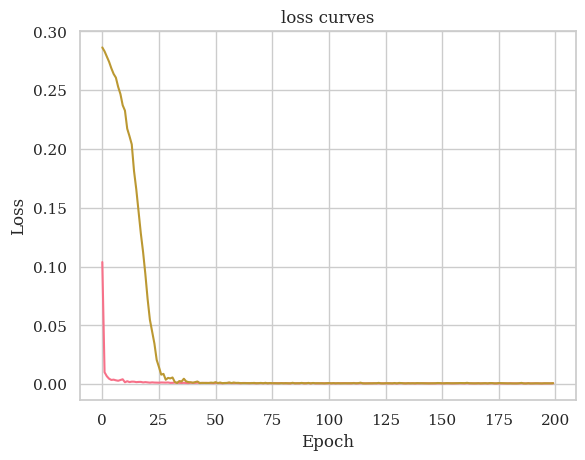

In [63]:
# loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

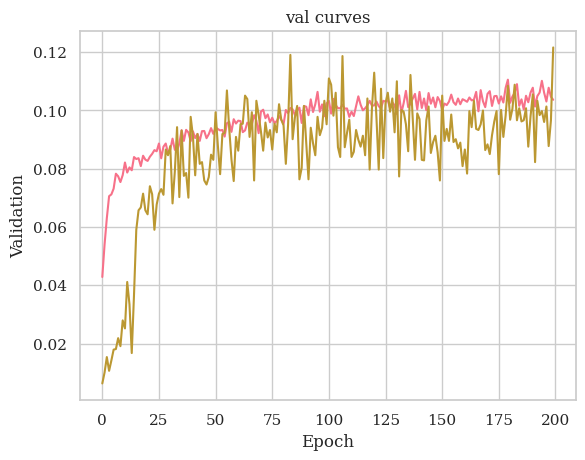

In [64]:
# loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('val curves')
plt.ylabel('Validation')
plt.xlabel('Epoch')
plt.show()

## Espaço latente

In [32]:
'''
from tensorflow.keras.models import load_model
caminho = '/content/drive/MyDrive/Unicamp/23.2/DL para sintese de sinais/Projetos computacionais/A1 - Projeto Final/Códigos/'
# Carregar o modelo
vae_carregado = load_model(caminho+'modelo_vae')
vae_carregado.summary()
'''

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1, 22, 400)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               686644    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1, 22, 400)        910785    
                                                                 
Total params: 1597429 (6.09 MB)
Trainable params: 1597045 (6.09 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [65]:
# 2D plot of the classes in latent space
latent_space, _, _ = encoder.predict(X_test,batch_size=batch_size)

8/8 [==============================] - 0s 4ms/step


A figura abaixo mostra o espaço latente do dados gerados

In [68]:
# Aplicar K-means
num_clusters = 4  # Número de clusters igual ao número de labels
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_space)

reducer = umap.UMAP(n_neighbors=10,min_dist=0.5) #50 e 0.5
embedding = reducer.fit_transform(latent_space)

# Visualizar UMAP
import plotly.express as px
proj = pd.DataFrame(embedding)
proj.columns = ["componente_1", "componente_2"]
proj["labels"] = y_train[:231]
fig = px.scatter(proj, x='componente_1', y='componente_2', color = cluster_labels, width=800)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

